# Modules and API

The first step that we must do is to import all the library and set up the Google Maps API with the necessary key to resolve our problem with Python.

In [ ]:
%pip install -U googlemaps
%pip install -U scikit-learn
%pip install polyline
%pip install networkx
import googlemaps
from googlemaps.exceptions import ApiError
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
import scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import networkx as nx
import folium
import polyline
api_key = "API_KEY"
gmaps_location = googlemaps.Client(key=api_key)

# Function to get coordinates and distances with the Google Maps API.

Continuing with the import of the libraries and configuring the Google Maps API, we have a function in charge of obtaining the coordinates of the city to be able to plot on a map.

In [ ]:
from geopy.geocoders import GoogleV3

geolocator = GoogleV3(api_key)

def obtener_coordenadas(ciudad):
    location = geolocator.geocode(ciudad)
    if location:
        return (location.latitude, location.longitude)
    else:
        return None

Now, we have a special function for obtaining the distances between two cities connected by road. If there is no connection between these cities, the function will return a large value to ensure it doesn't affect the clustering.

In [ ]:
def search_city(origin, destination, city_origin, city_destination):
  value = 0
  try:
    busqueda = gmaps_location.distance_matrix(origin, destination, mode="driving")
    value =  (busqueda['rows'][0]['elements'][0]['distance']['text']).split()[0].replace(',', '')
  except ApiError as e:
    print(f"Se produjo un error en la API de Google Maps: {e}")
  except Exception as e:
    value = 1000000

  return value

# Creation of Distance Matrix

Here, we have the most important function for solving our problem. The following function will be in charge of creating a distance matrix for the cities with an NxN dimension, making it symmetric, and then applying the agglomerative algorithm.

In [ ]:
citys = [line.strip() for line in open("ciudades.txt")]

distance = np.zeros((len(citys), len(citys)))

for city_origin in range(len(citys)):
  for city_destination in range(city_origin,len(citys)):
    if (city_origin==city_destination):
      distance[city_origin][city_destination] = 0
    else:
      distance[city_origin][city_destination] = search_city(citys[city_origin], citys[city_destination], city_origin, city_destination)
      distance[city_destination][city_origin] = distance[city_origin][city_destination]


In [ ]:
frame_ciudades = pd.DataFrame(distance, columns=citys)
frame_ciudades.to_excel('distancias.xlsx', index=False)
nombres = np.asarray(frame_ciudades.columns)

# Now here we create our model based on the agglomerative clustering function with the following parameters:

1. n_clusters=None: This means that no fixed number of clusters is specified a priori. Instead, the model will automatically determine the number of clusters based on the specified distance threshold.

2. distance_threshold=10000.0: You set a maximum distance threshold at 10000.0. This parameter is important in agglomerative clustering, as it determines when the clustering process stops. The agglomerative algorithm will merge the closest points into a cluster as long as the distance between them is less than this threshold.

3. compute_full_tree=True: This indicates that the model will compute the full clustering tree instead of stopping the process once the distance threshold is reached. This means that you will have information about all cluster merges that occurred, which can be useful for visualizing the hierarchical structure of the clusters.

4. metric='precomputed': This parameter specifies the type of metric that is used to calculate the distances between the points. In this case, we take this metric because we have already computed our distance matrix before.

5. linkage='single': Here you are specifying the type of linkage that will be used to merge the clusters. In this case, you are using the "single" linkage, this will merge the two closest clusters in each step of the algoritm.

In [ ]:
modelo = AgglomerativeClustering(
    n_clusters=None, 
    distance_threshold=10000.0,  
    compute_full_tree=True,
    metric='precomputed',  
    linkage='single'  
).fit(distance)

We then plotted a graph based on a dendrogram to better see the relationship of the agglomerative clustering.

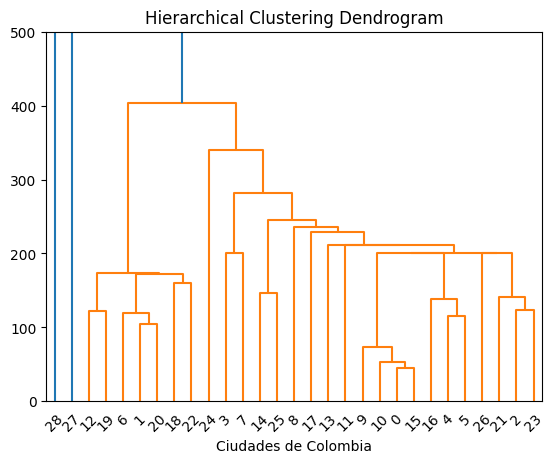

Sumado 1 al número en cada hoja se obtiene el índice del nombre de la ciudad


In [ ]:
def plot_dendrogram(model, **kwargs):

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(modelo, truncate_mode='level')
plt.ylim(0,500)
plt.xlabel("Colombian Cities")
plt.show()
print("Sumado 1 al número en cada hoja se obtiene el índice del nombre de la ciudad")
print(*enumerate(nombres))

# Minimum overlap tree

Finally, to our distance matrix we can calculate a minimum overlapping tree to be able to go through all the cities with the most optimal distances possible:

- We can establish a connection between Kruskal's algorithm and agglomerative clustering when our model is based on the "Single" distance metric. In this way, we can group clusters according to the closest distances between them. Likewise, in a minimum overlapping algorithm, we select the nodes that are connected and have the minimum weight to build our network.


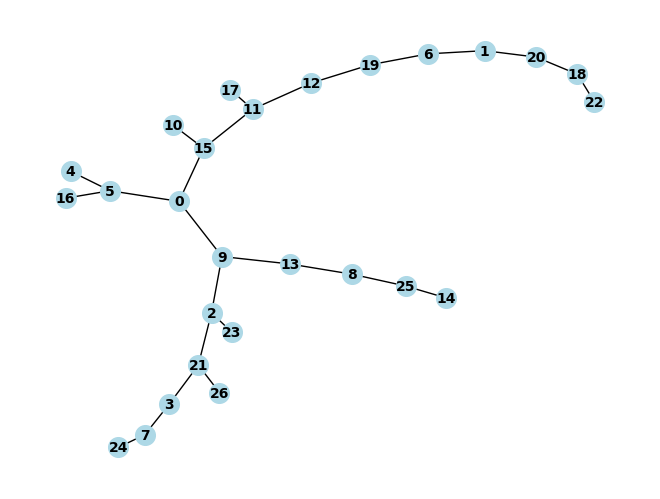

In [ ]:
distancedos = distance.copy()
distancedos[distancedos>=1000000] = 0
camino_minimo = scp.sparse.csgraph.minimum_spanning_tree(distancedos, overwrite=False)

filas, columnas = camino_minimo.nonzero()

aristas = list(zip(filas, columnas))


grafo = nx.Graph()
grafo.add_edges_from(aristas)


posiciones = nx.spring_layout(grafo)  
nx.draw(grafo, pos=posiciones, with_labels=True, node_size=200, node_color='lightblue', font_size=10, font_color='black', font_weight='bold')


plt.show()

Now, we plot our minimum overlapping tree with actual distances and locations on a map. 

In [ ]:
# Crear un mapa Folium centrado en alguna ubicación inicial
mapa = folium.Map(location=[4.570868, -74.297333], zoom_start=5)

# Addes a marker to the map
for value in filas:
  latitud, longitud = obtener_coordenadas(citys[value])
  folium.Marker(location=[latitud, longitud], tooltip=str(citys[value])).add_to(mapa)

# Addes a marker to the map
for value in columnas:
  latitud, longitud = obtener_coordenadas(citys[value])
  folium.Marker(location=[latitud, longitud], tooltip=str(citys[value])).add_to(mapa)

for edge in grafo.edges():
    nodo1, nodo2 = edge
    coords1 = obtener_coordenadas(citys[nodo1])
    coords2 = obtener_coordenadas(citys[nodo2])

    # we obtain the route between two points
    directions_result = gmaps_location.directions(coords1, coords2)

    # we obtain the polyline of the route
    route = directions_result[0]['overview_polyline']['points']

    # Decode polyline and add to map
    decoded_route = polyline.decode(route)

    # Added the route to the map
    folium.PolyLine(locations=decoded_route, color='blue').add_to(mapa)

# Show map
mapa